Runner for 3SAT/4SAT plus Data Analysis of Results, Daniel Espinosa 2024 UCSB ECE Strukov Group
Kissat, Linux

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
import xml.etree.ElementTree as Xet

In [2]:
%%capture
#this ipynb magic suppreses block outputs
# Keeping this as a default way of making plots, ignore
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
# mpl.rcParams['font.family'] = 'Times New Roman' RedHat does not have fonts yikes
plt.figure(figsize=(3.54,3.54), dpi=200)
plt.xlabel('Problem Instance', fontsize=10)
plt.ylabel('CPU Time (s)', fontsize=10)
plt.title('Kissat 3-SAT CPU Time Benchmark', fontsize=10)
y = [1,2,3,4]
x = range(len(y))
plt.plot(x,y,linewidth=0.5, label = "")

In [3]:
#   Template for parsing data later on
import subprocess
import os
'''
def run_command(x):
    #   Absolute path to the .cnf file is easier to use imo
    directory = "C:/.../mnci_56-3_pub"  
    cnf_file_path = os.path.join(directory, f"mnci_n56_t3_{x}_3sat.cnf")

    #   Not adapting to Linux
    cmd = f"./kissat {cnf_file_path}"
    proc = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    out, err = proc.communicate()

    if err:
        print(f"Error executing command for x={x}: {err.decode('utf-8')}")
        return None

    return out


#   Chatgpt code:
'''

def run_command(x):
    # Use a Linux-compatible path (replace with your actual path)
    directory = "/home/dirac/Documents/UMD\ QuICC\ instances/UMD\ QuICC\ instances/batch-01"
    cnf_file_path = os.path.join(directory, f"3block-like-rand-0000.cnf")

    # Directly call the executable without '.exe' extension
    # Ensure that 'glucose' is installed and accessible from the command line
    cmd = f"./kissat {cnf_file_path}"
    proc = subprocess.Popen(cmd, shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    out, err = proc.communicate()

    if err:
        print(f"Error executing command for x={x}: {err.decode('utf-8')}")
        return None

    return out.decode('utf-8')

# Example usage
output = run_command(0000)
print(output)

c ---- [ banner ] ------------------------------------------------------------
c
c Kissat SAT Solver
c 
c Copyright (c) 2021-2023 Armin Biere University of Freiburg
c Copyright (c) 2019-2021 Armin Biere Johannes Kepler University Linz
c 
c Version 3.1.1 71caafb4d182ced9f76cef45b00f37cc598f2a37
c gcc (GCC) 13.2.1 20231205 (Red Hat 13.2.1-6) -W -Wall -O3 -DNDEBUG
c Tue Jan 23 12:35:50 PM EST 2024 Linux dhcp185-117.ece.ucsb.edu 6.5.6-300.fc39.x86_64 x86_64
c
c ---- [ parsing ] -----------------------------------------------------------
c
c opened and reading DIMACS file:
c
c   /home/dirac/Documents/UMD QuICC instances/UMD QuICC instances/batch-01/3block-like-rand-0000.cnf
c
c parsed 'p cnf 50 275' header
c closing input after reading 3427 bytes (3 KB)
c finished parsing after 0.00 seconds
c
c ---- [ solving ] -----------------------------------------------------------
c
c  seconds switched conflicts irredundant variables
c         MB reductions redundant   trail  remaining
c          leve

In [4]:
import re
#   Parsing boilerplate for C output for given SAT solver, this one is for Kissat
def parse_output(output):
    data = {}

    #   Parse the required fields using regular expressions outputted by the solver
    #   This is different for Kissat now because Armin Biere likes semicolons
    patterns = {
        'restarts': r'c restarts:\s+\s+(\d+)',
        'conflicts': r'c conflicts:\s+\s+(\d+)',
        'decisions': r'c decisions:\s+\s+(\d+)',
        'propagations': r'c propagations:\s+\s+(\d+)',
        'cpu_time': r'c process-time:\s+\s+([\d.]+) s',
        'parse_time': r'c \|  Parse time:\s+([\d.]+) s',
        'num_variables': r'c \|  Number of variables:\s+(\d+)',
        'num_clauses': r'c \|  Number of clauses:\s+(\d+)',
        'simplification_time': r'c \|  Simplification time:\s+([\d.]+) s'
    }

    for key, pattern in patterns.items():
        match = re.search(pattern, output)
        if match:
            # Convert to appropriate data types
            if key in ['conflicts', 'decisions', 'propagations', 'num_variables', 'num_clauses']:
                data[key] = int(match.group(1))
            else:  # For cpu_time, parse_time, simplification_time
                data[key] = float(match.group(1))

    return data

In [5]:
a = run_command(2)
b = parse_output(a)

In [6]:
b #note I need to find out how to add number of variables into this

{'conflicts': 56, 'decisions': 64, 'propagations': 645, 'cpu_time': 0.0}

In [45]:
import sqlite3

#   Uncomment this to create your own local database, ideally with a different name for each solver
"""
conn = sqlite3.connect('kissat_data.db')
cursor = conn.cursor()

# Also change here!
cursor.execute('''
    CREATE TABLE IF NOT EXISTS kissat_data ( 
        id INTEGER PRIMARY KEY,
        instance_name TEXT,
        restarts INTEGER,
        num_variables INTEGER,
        num_clauses INTEGER,
        parse_time REAL,
        simplification_time REAL,
        conflicts INTEGER,
        decisions INTEGER,
        propagations INTEGER,
        cpu_time REAL
    )
''')

# Close the connection
conn.close()
"""


"\nconn = sqlite3.connect('kissat_data.db')\ncursor = conn.cursor()\n\n# Also change here!\ncursor.execute('''\n    CREATE TABLE IF NOT EXISTS kissat_data ( \n        id INTEGER PRIMARY KEY,\n        instance_name TEXT,\n        restarts INTEGER,\n        num_variables INTEGER,\n        num_clauses INTEGER,\n        parse_time REAL,\n        simplification_time REAL,\n        conflicts INTEGER,\n        decisions INTEGER,\n        propagations INTEGER,\n        cpu_time REAL\n    )\n''')\n\n# Close the connection\nconn.close()\n"

In [46]:
import os
import glob
import sqlite3
import subprocess

# Fastest way to do this TBH is just copy and pasting a Kissat binary into each folder ...
# which is what I did myself, you can always add a PATH variable to your executable but
# then you deal with more time overhead
#/home/dirac/Documents/UMD QuICC instances/UMD QuICC instances/batch-03/3block-like-rand-00000-0014.cnf on run 0

def parse_cnf_file(cnf_file_path):
    # assuming the cnf file path is a string 
    return cnf_file_path.replace('/UMD QuICC instances/UMD QuICC instances/', '/UMD\ QuICC\ instances/UMD\ QuICC\ instances/')


def run_kissat(cnf_file_path):
    
    #   Hacky way to use any .exe file in a cmd prompt since windows is not linux, do not change this or it all stops working
    #   Now it should be cd ... dir then ./kissat [file] instead of [file_path]
    #   Why? Glucose allowed global .exe access in Windows, here we run binaries in folders.
    cnf_file_path = parse_cnf_file(cnf_file_path)
    cmd = f"./kissat {cnf_file_path}"
    proc = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)
    out, err = proc.communicate()

    if err:
        print(f"Error executing command for file: {cnf_file_path}: {err.decode('utf-8')}")
        return None

    return out.decode('utf-8')

In [60]:
import sqlite3
import os
import glob
#   Assumes other required imports and functions (like run_glucose and parse_output) are already defined

num_runs_per_instance = 100  # Number of runs per .cnf file, now 0 because when I rerun everything I do not want more data, set to x!=0 to run
last_processed_file = r"/home/dirac/Documents/UMD\ QuICC\ instances/UMD\ QuICC\ instances/checkpoint" # Checkpoint system in case it breaks midway

#   Connect to the database
conn = sqlite3.connect('kissat_data.db') # Change to your database name as before
cursor = conn.cursor()

# Keep track of files that do not produce any data
non_responsive_files = set()

# Collect all .cnf files in the directory and subdirectories
directory = "/home/dirac/Documents/UMD QuICC instances/UMD QuICC instances" # Change to your problem directory with all the files
all_cnf_files = [os.path.join(subdir, file) for subdir, dirs, files in os.walk(directory) for file in files if file.endswith('.cnf')]


# Find the index of the last processed file (if it exists in the list)
# sorry for the hacky indenting here
if last_processed_file: 
    try:
        last_index = all_cnf_files.index(last_processed_file)
    except ValueError:
        last_index = -1  # If the last processed file is not found, start from the beginning

# Iterate through all .cnf files starting from the file after the last processed one
for file in all_cnf_files[last_index + 1:]:
    if file in non_responsive_files:
        print(f"Skipping non-responsive file: {file}")
        continue
    if num_runs_per_instance == 0:
        break

    for run in range(num_runs_per_instance):
        output = run_kissat(file) # change to your run_xyz function
        if output:
            data = parse_output(output)

            if data:
                try:
                    instance_name = os.path.basename(file)  # Extract the filename
                    cursor.execute('''
                        INSERT INTO kissat_data (
                            instance_name,
                            restarts,
                            num_variables, 
                            num_clauses, 
                            parse_time, 
                            simplification_time, 
                            conflicts, 
                            decisions, 
                            propagations, 
                            cpu_time
                        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
                    ''', (
                        instance_name,
                        data.get('restarts'),
                        data.get('num_variables'), 
                        data.get('num_clauses'), 
                        data.get('parse_time'), 
                        data.get('simplification_time'), 
                        data.get('conflicts'), 
                        data.get('decisions'), 
                        data.get('propagations'), 
                        data.get('cpu_time')
                    ))
                    conn.commit()
                except Exception as e:
                    print(f"Error inserting data for file {file} on run {run}: {e}")
            else:
                if run == 0:
                    non_responsive_files.add(file)
                    print(f"No data extracted for file {file} on first run, skipping subsequent runs.")
                    break
                print(f"No data extracted for file {file} on run {run}")
        else:
            print(f"No output for file {file} on run {run}")

# Close the connection
conn.close()

In [61]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Connect to the database and fetch the data
conn = sqlite3.connect('kissat_data.db')
df = pd.read_sql_query('SELECT cpu_time FROM kissat_data', conn)
conn.close()

# Calculate the average CPU time for each instance
avg_cpu_times = df.groupby('cpu_time').mean().reset_index()

# Sort the instances based on their average solve time
sorted_avg_cpu_times = avg_cpu_times.sort_values(by='cpu_time')

In [63]:
sum(avg_cpu_times["cpu_time"]) #on average, it took 67.44 seconds of CPU time to solve all the instances once

6.36

In [64]:
max(avg_cpu_times["cpu_time"])

0.46

In [ ]:
# Plot is saying okay, the max is 0.43 seconds, everything else is a ratio of that, that's not what we want
# instance / max(all_instances) tells you it took % of time of it, we care about the integral underneath the curve, plotting

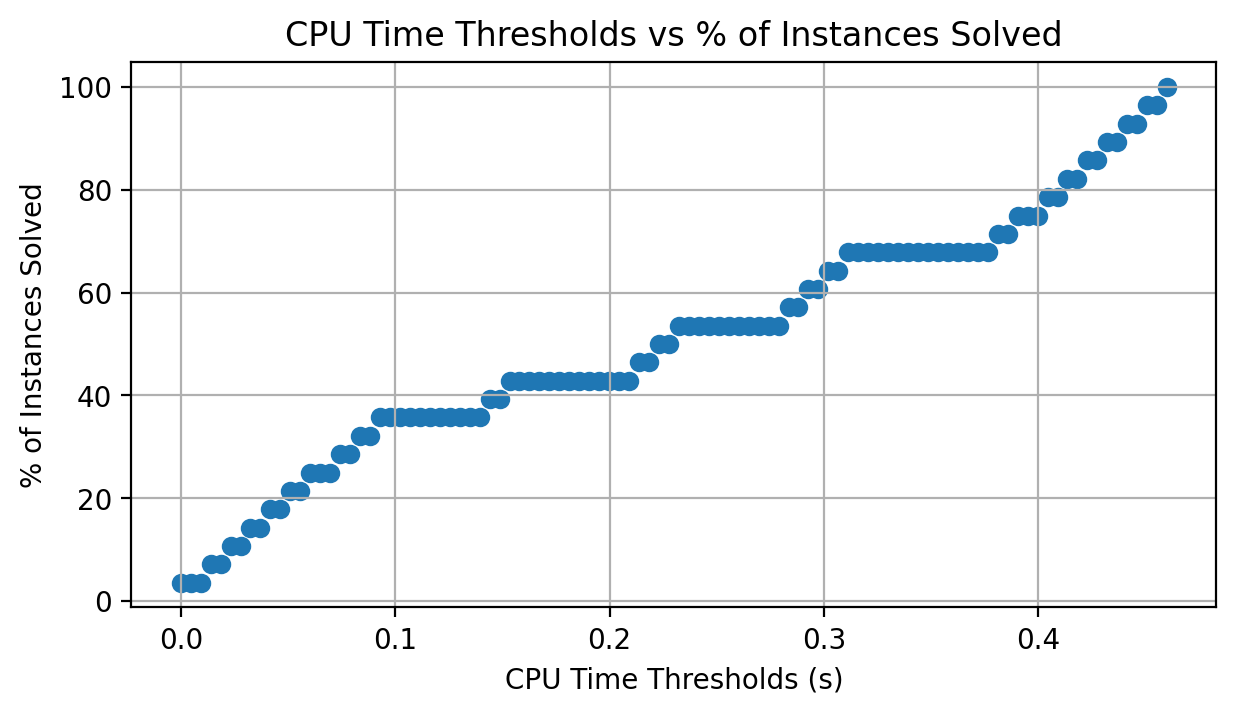

In [65]:
avg_cpu_times_sorted = avg_cpu_times.sort_values('cpu_time')

# Define discrete time intervals for treshhold plotter
max_time = avg_cpu_times['cpu_time'].max()
time_intervals = np.linspace(0, max_time, 100)  # Creates 100 evenly spaced time intervals up to the maximum time

# Calculate the percentage of instances solved for each interval
percent_solved = [100 * (avg_cpu_times['cpu_time'] <= t).mean() for t in time_intervals]

# Plotting
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
plt.figure(figsize=(7,3.54), dpi=200)
plt.scatter(time_intervals, percent_solved, marker='o')
plt.xlabel('CPU Time Thresholds (s)')
plt.ylabel('% of Instances Solved')
plt.title('CPU Time Thresholds vs % of Instances Solved')
plt.grid(True)
plt.show()


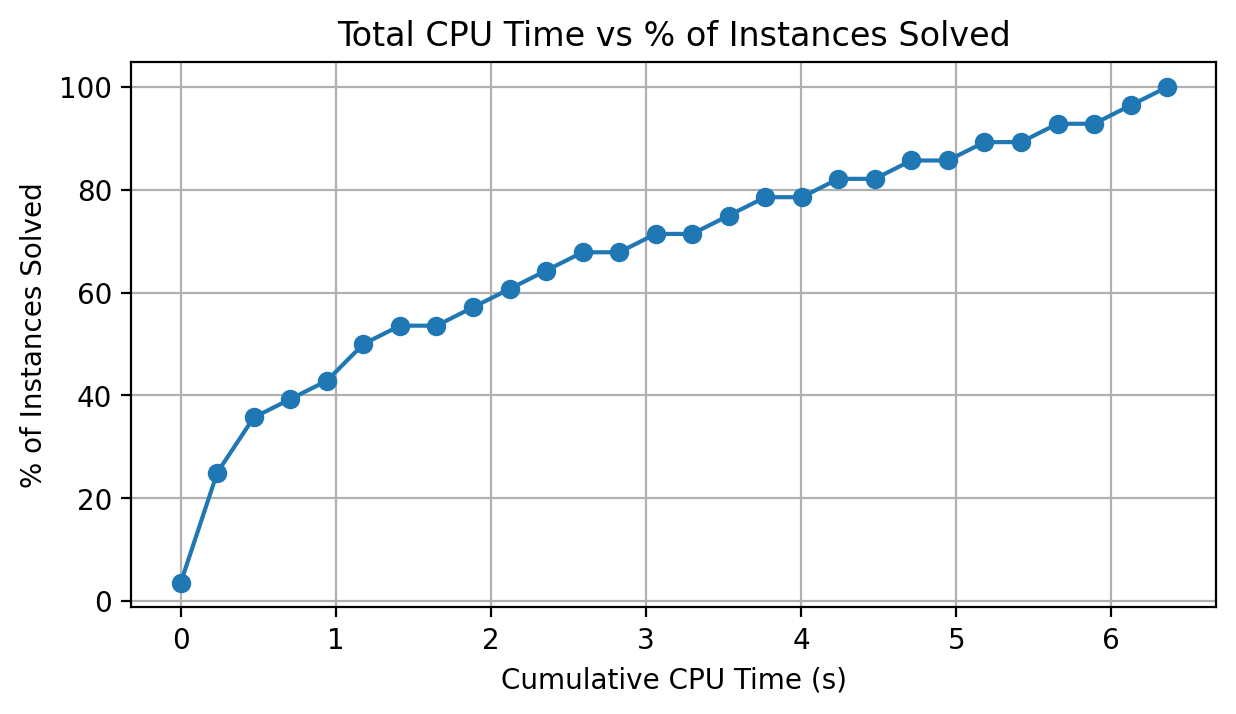

In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

# Sort the pd DataFrame by cpu_time
avg_cpu_times_sorted = avg_cpu_times.sort_values('cpu_time')

# Calculate cumulative CPU time
avg_cpu_times_sorted['cumulative_cpu_time'] = avg_cpu_times_sorted['cpu_time'].cumsum()

# Calculate the percentage of instances solved up to each point
avg_cpu_times_sorted['percent_solved'] = 100 * (avg_cpu_times_sorted.index + 1) / len(avg_cpu_times_sorted)

# Total sum of CPU time
sum_time = avg_cpu_times_sorted['cumulative_cpu_time'].iloc[-1]

# Define discrete time intervals as per NASA/UMD
time_intervals = np.linspace(0, sum_time, len(avg_cpu_times_sorted))  # Use the actual cumulative times

# Calculate percentage of instances solved for each interval
percent_solved = []
for t in time_intervals:
    percent_solved.append(100 * (avg_cpu_times_sorted['cumulative_cpu_time'] <= t).sum() / len(avg_cpu_times_sorted))

# Plotting settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Plotting
plt.figure(figsize=(7, 3.54), dpi=200)
plt.plot(time_intervals, percent_solved, marker='o') 
plt.xlabel('Cumulative CPU Time (s)')
plt.ylabel('% of Instances Solved')
plt.title('Total CPU Time vs % of Instances Solved')
plt.grid(True)
plt.show()

In [67]:
sum(avg_cpu_times['cpu_time'])

6.36

In [72]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Connect to the database and fetch the data
conn = sqlite3.connect('kissat_data.db')
df = pd.read_sql_query('SELECT instance_name, cpu_time FROM kissat_data', conn)
conn.close()

# Calculate the min and max CPU time for each instance
min_cpu_times = df.groupby('instance_name')['cpu_time'].min().reset_index()
max_cpu_times = df.groupby('instance_name')['cpu_time'].max().reset_index()

# Sort the instances based on solve times
sorted_avg_cpu_times = avg_cpu_times.sort_values(by='cpu_time')
min_cpu_times = min_cpu_times.sort_values(by='cpu_time')
max_cpu_times = max_cpu_times.sort_values(by='cpu_time')

In [79]:
stats_df

cpu_time            energy_usage_joules  \
                                       mean  std count                mean   
instance_name                                                                
3block-like-rand-0000.cnf               0.0  0.0   101                 0.0   
3block-like-rand-0038.cnf               0.0  0.0   101                 0.0   
3block-like-rand-00379-0173.cnf         0.0  0.0   101                 0.0   
3block-like-rand-00376-0069.cnf         0.0  0.0   202                 0.0   
3block-like-rand-00373-0047.cnf         0.0  0.0   101                 0.0   
...                                     ...  ...   ...                 ...   
stat-hard-4SAT-r-3-088993-0058.cnf      NaN  NaN     0                 NaN   
stat-hard-4SAT-r-3-093480-0005.cnf      NaN  NaN     0                 NaN   
stat-hard-4SAT-r-3-093817-0071.cnf      NaN  NaN     0                 NaN   
stat-hard-4SAT-r-3-098042-0038.cnf      NaN  NaN     0                 NaN   
stat-hard-4SAT-r-3-099832-0048.cnf      NaN  NaN     0                 NaN   

                                               
                                    std count  
instance_name                                  
3block-like-rand-0000.cnf           0.0   101  
3block-like-rand-0038.cnf           0.0   101  
3block-like-rand-00379-0173.cnf     0.0   101  
3block-like-rand-00376-0069.cnf     0.0   202  
3block-like-rand-00373-0047.cnf     0.0   101  
...                                 ...   ...  
stat-hard-4SAT-r-3-088993-0058.cnf  NaN     0  
stat-hard-4SAT-r-3-093480-0005.cnf  NaN     0  
stat-hard-4SAT-r-3-093817-0071.cnf  NaN     0  
stat-hard-4SAT-r-3-098042-0038.cnf  NaN     0  
stat-hard-4SAT-r-3-099832-0048.cnf  NaN     0  

[706 rows x 6 columns]

In [78]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import matplotlib as mpl

# Assuming pd df now has multiple cpu_time values for each instance_name
# Group by instance_name to calculate mean and standard deviation for each instance
stats_df = df.groupby('instance_name').agg(['mean', 'std', 'count'])

# Sort the instances by increasing average time to solution
stats_df = stats_df.sort_values(('cpu_time', 'mean'))

# Define the indices of the values you want to plot
selected_indices = [1097, 1098, 1099]  # Change as needed, for all use range(1110) etc.

# Subset the stats_df pd DataFrame to include only selected indices
selected_stats_df = stats_df.iloc[selected_indices]

# Calculate asymmetric error for the selected data points (where we see the max amount vs the min amount of time to solution)
min_cpu_times = df.groupby('instance_name')['cpu_time'].min()
max_cpu_times = df.groupby('instance_name')['cpu_time'].max()

asymmetric_error = [
    selected_stats_df[('cpu_time', 'mean')] - min_cpu_times[selected_stats_df.index],
    max_cpu_times[selected_stats_df.index] - selected_stats_df[('cpu_time', 'mean')]
]

# Extract instance names for the selected instances
selected_instance_names = selected_stats_df.index

# Plotting settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Plotting
plt.figure(figsize=(7, 3.54), dpi=200)

# Plotting
plt.errorbar(
    x=selected_instance_names,  # X-axis: Instance names
    y=selected_stats_df[('cpu_time', 'mean')],  # Y-axis: Mean CPU time
    yerr=asymmetric_error,  # Error: Asymmetric error for selected data
    fmt='.',  # Format string for the points
    ecolor='red',  # Color of the error bars
    capsize=5  # Caps on the error bars
)

plt.xlabel('Instance Name')
plt.ylabel('CPU Time (s)')
plt.title('CPU Time per Instance with Error Bars')
plt.grid(True)

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

plt.show()

IndexError: positional indexers are out-of-bounds

In [ ]:
stats_df.keys()

In [73]:
import sqlite3
import pandas as pd

# Connect to the database
conn = sqlite3.connect('kissat_data.db')

# Prepare the query to select data for a specific instance_name
instance_to_query = 'mnci_n24_t3_1_3sat.cnf'  # Specify the instance_name you want to query
query = f"SELECT * FROM kissat_data WHERE instance_name = '{instance_to_query}'"

# Load the data into a pandas DataFrame
x = pd.read_sql_query(query, conn)

# Display the DataFrame
print(x)

# Close the database connection
conn.close()

Empty DataFrame
Columns: [id, instance_name, restarts, num_variables, num_clauses, parse_time, simplification_time, conflicts, decisions, propagations, cpu_time]
Index: []


In [77]:
min_cpu_times[selected_stats_df.index]

instance_name
3block-like-rand-0000.cnf             0.0
3block-like-rand-0038.cnf             0.0
3block-like-rand-00379-0173.cnf       0.0
3block-like-rand-00376-0069.cnf       0.0
3block-like-rand-00373-0047.cnf       0.0
                                     ... 
stat-hard-4SAT-r-3-088993-0058.cnf    NaN
stat-hard-4SAT-r-3-093480-0005.cnf    NaN
stat-hard-4SAT-r-3-093817-0071.cnf    NaN
stat-hard-4SAT-r-3-098042-0038.cnf    NaN
stat-hard-4SAT-r-3-099832-0048.cnf    NaN
Name: cpu_time, Length: 706, dtype: float64

ValueError: 'yerr' must not contain negative values

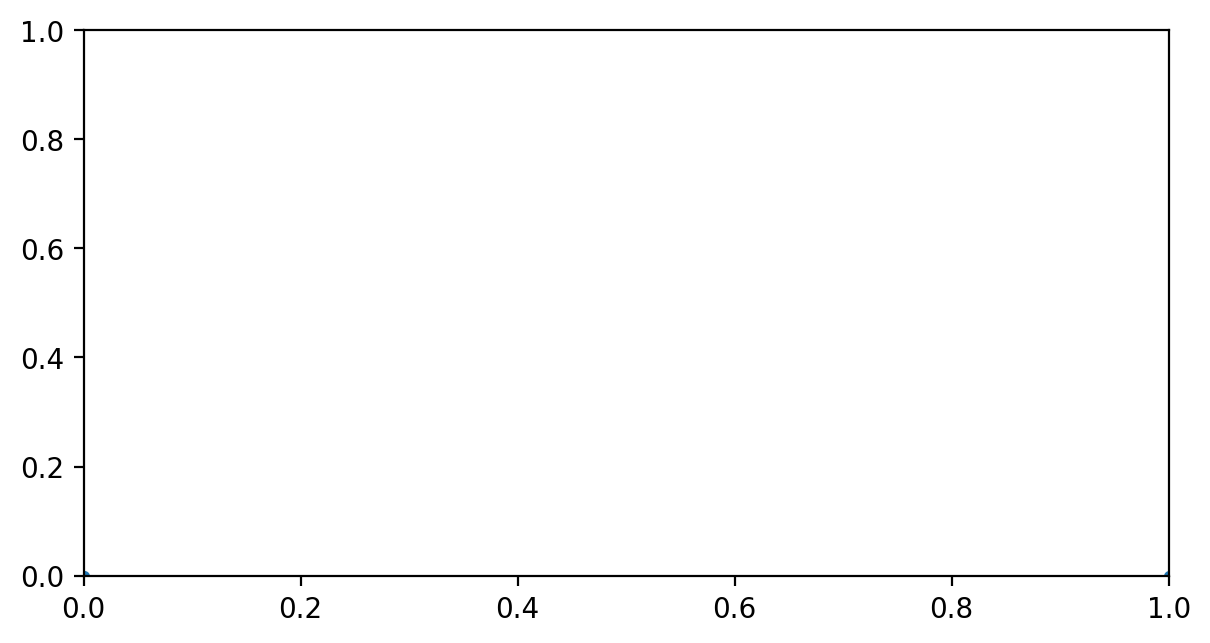

In [76]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import matplotlib as mpl

# Assuming df now has multiple cpu_time values for each instance_name
# Group by instance_name to calculate mean and standard deviation for each instance
stats_df = df.groupby('instance_name').agg(['mean', 'std', 'count'])

# Sort the instances by increasing average time to solution
stats_df = stats_df.sort_values(('cpu_time', 'mean'))

# Define the indices of the 10 values you want to plot
selected_indices = range(1100)  # Change these indices as needed

# Subset the stats_df DataFrame to include only the selected indices
selected_stats_df = stats_df

# Calculate asymmetric error for the selected data points
min_cpu_times = df.groupby('instance_name')['cpu_time'].min()
max_cpu_times = df.groupby('instance_name')['cpu_time'].max()

asymmetric_error = [
    selected_stats_df[('cpu_time', 'mean')] - min_cpu_times[selected_stats_df.index],
    max_cpu_times[selected_stats_df.index] - selected_stats_df[('cpu_time', 'mean')]
]

# Plotting settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Plotting
plt.figure(figsize=(7, 3.54), dpi=200)

# Plotting
plt.errorbar(
    x=range(len(selected_stats_df)),  # X-axis: Instance number after sorting
    y=selected_stats_df[('cpu_time', 'mean')],  # Y-axis: Mean CPU time
    yerr=asymmetric_error,  # Error: Asymmetric error for selected data
    fmt='.',  # Format string for the points
    ecolor='red',  # Color of the error bars
    capsize=5  # Caps on the error bars
)

plt.xlabel('Instance Number (ordered by increasing average time to solution)')
plt.ylabel('CPU Time (s)')
plt.title('CPU Time per Instance with Error Bars')
plt.grid(True)
plt.show()

In [ ]:
x.keys()

In [74]:
def calculate_energy_usage_joules(cpu_time_seconds, average_power_watts):
    # 1 Watt = 1 Joule/second
    energy_joules = average_power_watts * cpu_time_seconds

    return energy_joules

# Example
cpu_time_seconds = 0.5 
average_power_watts = 45  # Replace with the average power consumption in watts (TDP or measured value) of your specific CPU

# Once we are using analog devices or doing approximation prblems, we expect this relationship to be nonlinear
# then we can keep track of "average_power_watts" as a variable of interest in our SQL database !!!

energy_usage_joules = calculate_energy_usage_joules(cpu_time_seconds, average_power_watts)
print(f"Energy Usage: {energy_usage_joules} Joules")

Energy Usage: 22.5 Joules


In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import matplotlib as mpl

# Function to calculate energy usage in Joules
def calculate_energy_usage_joules(cpu_time_seconds, average_power_watts):
    energy_joules = average_power_watts * cpu_time_seconds
    return energy_joules


average_power_watts = 45  # Replace with actual average power consumption in watts for given CPU
df['energy_usage_joules'] = df['cpu_time'].apply(lambda x: calculate_energy_usage_joules(x, average_power_watts))


# Assuming 'df' now has multiple cpu_time values for each instance_name
# Group by instance_name to calculate mean and standard deviation for each instance
stats_df = df.groupby('instance_name').agg(['mean', 'std', 'count'])

# Sort the instances by increasing average energy to solution
stats_df = stats_df.sort_values(('energy_usage_joules', 'mean'))

# Define the indices of the values we want to plot
selected_indices = range(1100)   

# Subset the stats_df DataFrame to include only the selected indices
selected_stats_df = stats_df.iloc[selected_indices]

# Calculate the asymmetric error for the selected data points
min_energy_use = df.groupby('instance_name')['energy_usage_joules'].min()
max_energy_use = df.groupby('instance_name')['energy_usage_joules'].max()

asymmetric_error_energy = [
    selected_stats_df[('energy_usage_joules', 'mean')] - max_energy_use[selected_stats_df.index],
    min_energy_use[selected_stats_df.index] - selected_stats_df[('energy_usage_joules', 'mean')]
]

# Plotting settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Plotting
plt.figure(figsize=(7, 3.54), dpi=200)

# Plotting
plt.errorbar(
    x=range(len(selected_stats_df)),  # X-axis: Instance number after sorting
    y=selected_stats_df[('energy_usage_joules', 'mean')],  # Y-axis: Mean CPU time
    yerr=asymmetric_error_energy,  # Error: Asymmetric error for selected data
    fmt='.',  # Format string for the points
    ecolor='red',  # Color of the error bars
    capsize=5  # Caps on the error bars
)

plt.xlabel('Instance Number (ordered by increasing average time to solution)')
plt.ylabel('Joules (Ws)')
plt.title('Energy per Instance with Error Bars')
plt.grid(True)
plt.show()



IndexError: positional indexers are out-of-bounds

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import matplotlib as mpl
#   Uncomment to splice the data and plot only some subsections, issue is it also removes it for the below plot, hence commented out
"""
# Assuming 'df' now has multiple cpu_time values for each instance_name
# Group by instance_name to calculate mean and standard deviation for each instance
stats_df = df.groupby('instance_name').agg(['mean', 'std', 'count'])

# Sort the instances by increasing average time to solution
stats_df = stats_df.sort_values(('energy_usage_joules', 'mean'))

# Define the indices of the 10 values you want to plot
selected_indices = [1097, 1098, 1099]  # Change these indices as needed

# Subset the stats_df DataFrame to include only the selected indices
selected_stats_df = stats_df.iloc[selected_indices]

# Calculate the asymmetric error for the selected data points
min_cpu_times = df.groupby('instance_name')['energy_usage_joules'].min()
max_cpu_times = df.groupby('instance_name')['energy_usage_joules'].max()

asymmetric_error = [
    selected_stats_df[('energy_usage_joules', 'mean')] - min_cpu_times[selected_stats_df.index],
    max_cpu_times[selected_stats_df.index] - selected_stats_df[('energy_usage_joules', 'mean')]
]

# Extract instance names for the selected instances
selected_instance_names = selected_stats_df.index

# Plotting settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.family'] = 'Times New Roman'

# Plotting
plt.figure(figsize=(7, 3.54), dpi=200)

# Plotting
plt.errorbar(
    x=selected_instance_names,  # X-axis: Instance names
    y=selected_stats_df[('energy_usage_joules', 'mean')],  # Y-axis: Mean CPU time
    yerr=asymmetric_error,  # Error: Asymmetric error for selected data
    fmt='.',  # Format string for the points
    ecolor='red',  # Color of the error bars
    capsize=5  # Caps on the error bars
)

plt.xlabel('Instance Name')
plt.ylabel('Joules (Ws)')
plt.title('Energy per Instance with Error Bars')
plt.grid(True)

# Rotate x-axis labels for better visibility if needed
plt.xticks(rotation=45)

plt.show()"""

In [ ]:
# now putting it all together, energy vs time plot :

import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import matplotlib as mpl

# Plotting
plt.figure(figsize=(7, 3.54), dpi=200)

# Define the indices of the values we want to plot
selected_indices = range(1100)   

# Subset the stats_df DataFrame to include only the selected indices
selected_stats_df = stats_df.iloc[selected_indices]


# Plotting
plt.errorbar(
    x=selected_stats_df[('cpu_time', 'mean')],  # X-axis: Instance number after sorting
    y=selected_stats_df[('energy_usage_joules', 'mean')],  # Y-axis: Mean CPU time
    xerr=asymmetric_error,
    yerr=asymmetric_error_energy,  # Error: Asymmetric error because size(min) != size(max)
    fmt='.',  # Format string for the points
    ecolor='red',  # Color of the error bars
    capsize=5  # Caps on the error bars
)

plt.xlabel('CPU Time (s)')
plt.ylabel('Joules (Ws)')
plt.title('Energy vs CPU Time per Instance')
plt.grid(True)
plt.show()

In [ ]:
# now putting it all together, energy vs time plot min vs max:

import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import matplotlib as mpl

# Plotting
plt.figure(figsize=(7, 3.54), dpi=200)

# Define the indices of the values we want to plot
selected_indices = range(1100)   

# Subset the stats_df DataFrame to include only the selected indices
selected_stats_df = stats_df.iloc[selected_indices]


# Plotting
plt.errorbar(
    x=max_cpu_times, #   selected_stats_df[('cpu_time', 'mean')],  # X-axis: Instance number after sorting
    y=max_energy_use, #    selected_stats_df[('energy_usage_joules', 'mean')],  # Y-axis: Mean CPU time
    fmt='.',  # Format string for the points
    ecolor='red',
    label='max',  # Color of the error bars
    capsize=5  # Caps on the error bars
)


plt.errorbar(
    x=min_cpu_times, #   selected_stats_df[('cpu_time', 'mean')],  # X-axis: Instance number after sorting
    y=min_energy_use, #    selected_stats_df[('energy_usage_joules', 'mean')],  # Y-axis: Mean CPU time
    fmt='.',  # Format string for the points
    ecolor='red',
    label='min',  # Color of the error bars
    capsize=5  # Caps on the error bars
)

plt.xlabel('CPU Time (s)')
plt.ylabel('Joules (Ws)')
plt.title('Energy vs CPU Time per Instance')
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import matplotlib as mpl

# Assuming 'df' now has multiple cpu_time values for each instance_name
# Group by instance_name to calculate mean and standard deviation for each instance
stats_df = df.groupby('instance_name').agg(['mean', 'std', 'count'])

# Sort the instances by increasing average time to solution
stats_df = stats_df.sort_values(('cpu_time', 'mean'))

# Define the indices of the 10 values you want to plot
selected_indices = [1099, 1098, 1097, 1096]  # Change these indices as needed

# Subset the stats_df DataFrame to include only the selected indices
selected_stats_df = stats_df.iloc[selected_indices]

# Calculate the asymmetric error for the selected data points
min_cpu_times = df.groupby('instance_name')['cpu_time'].min()
max_cpu_times = df.groupby('instance_name')['cpu_time'].max()

min_energy = df.groupby('instance_name')['energy_usage_joules'].min()
max_energy = df.groupby('instance_name')['energy_usage_joules'].max()

asymmetric_error = [
    selected_stats_df[('cpu_time', 'mean')] - min_cpu_times[selected_stats_df.index],
    max_cpu_times[selected_stats_df.index] - selected_stats_df[('cpu_time', 'mean')]
]

asymmetric_error_energy = [
    selected_stats_df[('energy_usage_joules', 'mean')] - min_energy[selected_stats_df.index],
    max_energy[selected_stats_df.index] - selected_stats_df[('energy_usage_joules', 'mean')]
]

# Extract instance names for the selected instances
selected_instance_names = selected_stats_df.index

# Plotting settings
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# Plotting
plt.figure(figsize=(7, 3.54), dpi=200)

# Plotting
plt.errorbar(
    x=selected_stats_df[('cpu_time', 'mean')],  # X-axis: Mean CPU time
    y=selected_stats_df[('energy_usage_joules', 'mean')],  # Y-axis: Mean Energy use
    xerr=asymmetric_error,
    yerr=asymmetric_error_energy,    
    fmt='.',  # Format string for the points
    ecolor='red',  # Color of the error bars
    capsize=5  # Caps on the error bars
)

plt.xlabel('CPU Time (s)')
plt.ylabel('Joules (Ws)')
plt.title('Energy vs CPU Time per Instance')
plt.grid(True)

plt.show()

In [ ]:
#import sqlite3
# Code to delete all of the database
# Connect to the database
# DO NOT RUN THIS UNLESS YOU WANT TO DELETE ALL OF THE DATA conn = sqlite3.connect('glucose_data.db')
# DO NOT RUN THIS UNLESS YOU WANT TO DELETE ALL OF THE DATA cursor = conn.cursor()
# Delete all records from the table
# DO NOT RUN THIS UNLESS YOU WANT TO DELETE ALL OF THE DATA cursor.execute('DELETE FROM glucose_data')
# Commit the changes
# DO NOT RUN THIS UNLESS YOU WANT TO DELETE ALL OF THE DATA conn.commit()

#print("All records have been deleted from glucose_data table.")

# Close the connection
#conn.close()